# Appendix D:  Validation of FDR’s control of false positive node proportion

FDR interprets $\alpha$ as the following 'false positive node proportion':

$$ \alpha = \frac{  n_\textrm{false}  }{  n_\textrm{significant}  } $$

where:

* $n_\textrm{false}$ is the number of false positive nodes
* $n_\textrm{significant}$ is the number of significant nodes, or equivalently the number of true positives plus the number of false positives

A validation of FDR's control of this proportion is provided in the 'Validation' sections below. Prior to that validation let's consider how this proportion can be computed for a single 1D sample.

___

### Computing the false positive node proportion for a single 1D sample

Let's first import the required modules.

In [1]:
import numpy as np
from matplotlib import pyplot
import spm1d
import fdr1d

Before starting to validate FDR we must consider the following conundrum: if there is no true signal, then all significant nodes are false positives, and $\alpha$=1 by definition. This implies that FDR cannot be validated when there is no true signal. We must instead start with a true signal, because this permits $\alpha$<1, and we can then check whether FDR accurately controls arbitrarily small $\alpha$ values.

Note the following conundrum: if there is no true signal, then all significant nodes are false positives, so $\alpha$=1 by definition. Thus FDR cannot be validated when there is no true signal. We must instead instroduce true signal. For simplicity let's create a simple binary signal so that we know exactly which nodes contain signal.

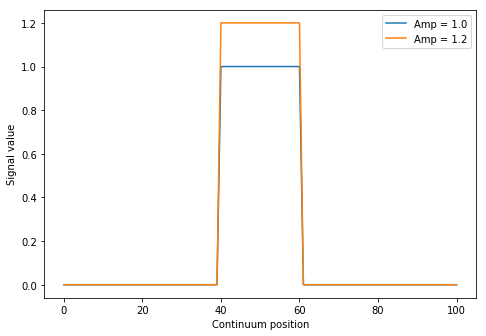

In [2]:
Q         = 101         #number of continuum nodes
signal    = np.zeros(Q) #initialize signal
signal[40:61] = 1       #set signal nodes

amp0      = 1.0         #an arbitrary signal amplitude
amp1      = 1.2         #another arbitrary signal amplitude


#plot:
pyplot.figure()
ax        = pyplot.axes([0, 0, 1, 1])
ax.plot( amp0 * signal, label='Amp = %.1f'%amp0 )
ax.plot( amp1 * signal, label='Amp = %.1f'%amp1 )
ax.set_xlabel('Continuum position')
ax.set_ylabel('Signal value')
ax.legend()
pyplot.show()

Next let's add noise to this signal. Here we'll use uncorrelated (completely rough) 1D noise, and below we'll use smooth 1D noise.

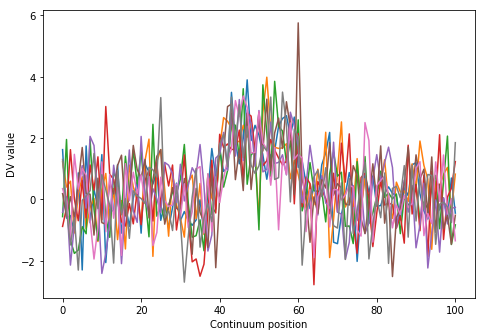

In [3]:
np.random.seed(1)
J         = 8                       #sample size 
noise     = np.random.randn(J, Q)   #uncorrelated Gaussian noise
y         = (1.8 * signal) + noise  #random sample containing true signal


pyplot.figure()
ax        = pyplot.axes([0, 0, 1, 1])
ax.plot( y.T )
ax.set_xlabel('Continuum position')
ax.set_ylabel('DV value')
pyplot.show()

Note that the signal is visible between positions 40 and 60. Next let's compute the 1D test statistic and calculate the FDR threshold for $\alpha$=0.05.

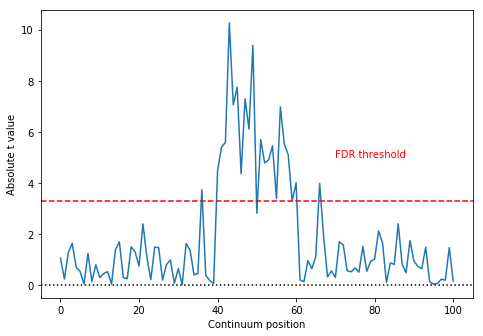

In [4]:
alpha     = 0.05
df        = J - 1
t         = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
t_abs     = np.abs(t)
tstar_fdr = fdr1d.inference(t_abs, df, alpha, 'T')



pyplot.figure()
ax        = pyplot.axes([0, 0, 1, 1])
ax.plot( t_abs )
ax.axhline(0, color='k', ls=':')
ax.axhline(tstar_fdr, color='r', ls='--')
ax.text(70, 5.0, 'FDR threshold', color='r')
ax.set_xlabel('Continuum position')
ax.set_ylabel('Absolute t value')
pyplot.show()

The FDR threshold has captured almost all of the true signal between positions 40 and 60. However, it has additionally captured two false positives outside the region of the true signal. The false positive node proportion for this sample can be calculated as follows:  

In [5]:
b_trueneg    = signal == 0         #binary continuum indicating true negative nodes
b_pos        = t_abs > tstar_fdr   #binary continuum indicating positive (suprathreshold) nodes

npos         = b_pos.sum()         #number of positive (suprathreshold) nodes
nfalsepos    = b_pos[b_trueneg].sum()  #number of false positive nodes

p            = nfalsepos / npos    #false positive node proportion

print('Number of positive (suprathreshold) nodes: %d' %npos)
print('Number of false positive nodes: %d' %nfalsepos)
print('Proportion of false positive nodes: %.3f' %p)

Number of positive (suprathreshold) nodes: 21
Number of false positive nodes: 2
Proportion of false positive nodes: 0.095


This false positive node proportion (FPNP) can alternatively be computed using **fdr1d.fpnp**:

In [6]:
p           = fdr1d.fpnp(t, tstar_fdr, signal)

print('Proportion of false positive nodes: %.3f' %p)

Proportion of false positive nodes: 0.095


In this case the FDR threshold has yielded a false positive node proportion greater than $\alpha$=0.05.  However, $\alpha$ pertains to the infinite set of similar datasets and not just to a single dataset. To validate FDR's control of $\alpha$ we must simulate a large number of datasets.

___

### Validation  (uncorrelated 1D noise)

Let's repeat the single-sample analysis from above for a large number of datasets. Let's start with just ten datasets.

In [7]:
nIter     = 10  #number of simulation iterations
P         = []  #proportion of false positive nodes for each iteration

np.random.seed(0)
for i in range(nIter):
    noise = np.random.randn(J, Q)
    y     = (1.8 * signal) + noise
    t     = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
    t     = np.abs(t)
    tstar = fdr1d.inference(t, df, alpha, 'T')
    p     = fdr1d.fpnp(t, tstar_fdr, signal)
    P.append(p)
P         = np.asarray(P)    

print('Average false positive node proportion = %.3f' %P.mean())
print()
print('Proportions for all iterations:')
for i,p in enumerate(P):
    print('    Iteration %d:   %.3f' %(i,p))

Average false positive node proportion = 0.039

Proportions for all iterations:
    Iteration 0:   0.050
    Iteration 1:   0.000
    Iteration 2:   0.045
    Iteration 3:   0.053
    Iteration 4:   0.100
    Iteration 5:   0.000
    Iteration 6:   0.087
    Iteration 7:   0.056
    Iteration 8:   0.000
    Iteration 9:   0.000


The overall (average) false positive node proportion is now somewhat closer to the expected $\alpha$=0.05. Let's now repeat for a larger number of iterations.

Average false positive node proportion = 0.04963


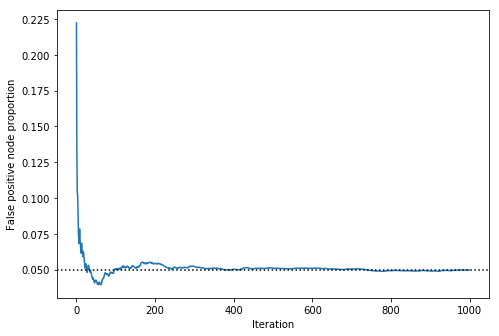

In [8]:
nIter     = 1000 #number of simulation iterations
P         = []   #proportion of false positive nodes for each iteration

np.random.seed(4)
for i in range(nIter):
    noise = np.random.randn(J, Q)
    y     = (2.5 * signal) + noise
    t     = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
    t     = np.abs(t)
    tstar = fdr1d.inference(t, df, alpha, 'T')
    p     = fdr1d.fpnp(t, tstar, signal)
    P.append(p)
P         = np.asarray(P)    

print('Average false positive node proportion = %.5f' %P.mean())


pyplot.figure()
ax        = pyplot.axes( [0, 0, 1, 1] )
ax.plot( np.cumsum(P) / np.arange(1,P.size+1) )
ax.axhline(alpha, color='k', ls=':')
ax.set_xlabel('Iteration')
ax.set_ylabel('False positive node proportion')
pyplot.show()

The overall (average) false positive node proportion has converged closely to the expected $\alpha$=0.05. This validates FDR thresholds for rough 1D noise, but how about smooth 1D noise?

___

### Validation (smooth 1D noise)

Adding smooth 1D noise to our signal results in datasets that look like this:

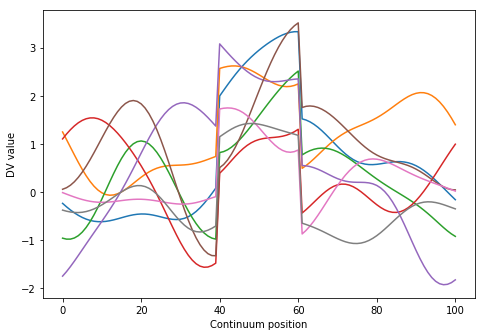

In [9]:
randn1d   = spm1d.rft1d.randn1d

np.random.seed(1)
W         = 20               #smoothness
noise     = randn1d(J, Q, W) #correlated (smooth) Gaussian noise
y         = (1.8 * signal) + noise  #random sample containing true signal


pyplot.figure()
ax        = pyplot.axes([0, 0, 1, 1])
ax.plot( y.T )
ax.set_xlabel('Continuum position')
ax.set_ylabel('DV value')
pyplot.show()

And like above we can compute the 1D test statistic, the FDR threshold, and the false positive node proportion as follows:

Proportion of false positive nodes: 0.000


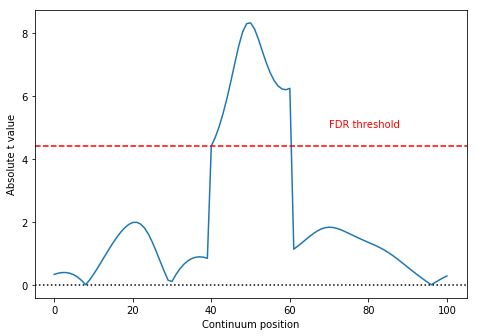

In [10]:
t         = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
t_abs     = np.abs(t)
tstar_fdr = fdr1d.inference(t_abs, df, alpha, 'T')


p         = fdr1d.fpnp(t, tstar_fdr, signal)
print('Proportion of false positive nodes: %.3f' %p)


pyplot.figure()
ax        = pyplot.axes([0, 0, 1, 1])
ax.plot( t_abs )
ax.axhline(0, color='k', ls=':')
ax.axhline(tstar_fdr, color='r', ls='--')
ax.text(70, 5.0, 'FDR threshold', color='r')
ax.set_xlabel('Continuum position')
ax.set_ylabel('Absolute t value')
pyplot.show()

Here there are no false positive nodes. Let's repeat for a large number of iterations.

Average false positive node proportion = 0.05683


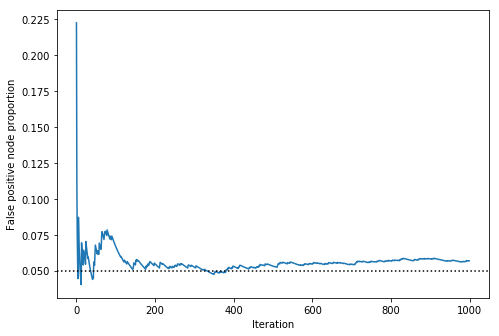

In [11]:
nIter     = 1000 #number of simulation iterations
P         = []   #proportion of false positive nodes for each iteration

np.random.seed(0)
for i in range(nIter):
    noise = randn1d(J, Q, W, pad=True)
    y     = (1.8 * signal) + noise
    t     = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
    t     = np.abs(t)
    tstar = fdr1d.inference(t, df, alpha, 'T')
    p     = fdr1d.fpnp(t, tstar, signal)
    P.append(p)
P         = np.asarray(P)    

print('Average false positive node proportion = %.5f' %P.mean())


pyplot.figure()
ax        = pyplot.axes( [0, 0, 1, 1] )
ax.plot( np.cumsum(P) / np.arange(1,nIter+1) )
ax.axhline(alpha, color='k', ls=':')
ax.set_xlabel('Iteration')
ax.set_ylabel('False positive node proportion')
pyplot.show()

Since the average false positive node proportion in simulated data is close to $\alpha$ we can conclude that the FDR approach also appears to be valid for smooth 1D data. 